In [2]:
import gpflow as gpf
import numpy as np
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from time import time
import tensorflow as tf
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os
from link_bot_notebooks import experiments_util
tf.logging.set_verbosity(tf.logging.FATAL)
np.set_printoptions(suppress=True, precision=4, linewidth=200)

In [4]:
plt.style.use("slides")

In [5]:
def make_relative_to_head(states):
    states_relative_to_head = np.copy(states)
    assert states.ndim > 1
    # flatten then reshape to make this function work for N-dim arrays
    states_relative_to_head = states_relative_to_head.reshape(-1, states.shape[-1])
    for s in states_relative_to_head:
        s[0] -= s[4]
        s[1] -= s[5]
        s[2] -= s[4]
        s[3] -= s[5]
        s[4] = 0
        s[5] = 0
    return states_relative_to_head.reshape(states.shape)
    
def format_forward_data(data, traj_idx_start=0, traj_idx_end=-1):
    """
    input to the forward model is a position of each point on the rope relative to the head,
    concatentated with the control input
    """
    states = data['states'][traj_idx_start:traj_idx_end]
    actions = data['actions'][traj_idx_start:traj_idx_end]
    
    # compute the delta in world frame
    delta = states[:, 1:] - states[:, :-1]
    # make input data more zero centered by making things relative to the head
    states_relative_to_head = make_relative_to_head(states)
        
    # flatten & concatenate data into various useful formats
    states_flat = states_relative_to_head[:, :-1].reshape(-1, 6)  # ignore the last time step because it has no corresponding output
    actions_flat = actions[:, :, :].reshape(-1, 2)
    combined_x = np.concatenate((states_flat, actions_flat), axis=1)
    delta_flat = delta.reshape(-1, 6)
    
    return states_flat, delta_flat, actions_flat, combined_x, states[:, :-1], actions

def format_inverse_data(data, traj_idx_start=0, traj_idx_end=-1, take_every=1):
    states = data['states'][traj_idx_start:traj_idx_end]
    actions = data['actions'][traj_idx_start:traj_idx_end]
    
    delta = states[:, take_every:] - states[:, :-take_every]
        
    delta_flat = delta.reshape(-1, 6)
    if take_every == 1:
        actions_flat = actions.reshape(-1, 2)
    else:
        actions_flat = actions[:, :(-take_every+1)].reshape(-1, 2)
    mag_flat = np.linalg.norm(actions_flat, axis=1).reshape(-1, 1)
    actions_flat_scaled = actions_flat / np.linalg.norm(actions_flat, axis=1).reshape(-1, 1)
    # the action representation here is cos(theta), sin(theta), magnitude
    # I think this is better than predicting just components or mag/theta
    # because theta is discontinuous and GPs assume smoothness
    angle_actions_flat = np.concatenate((actions_flat_scaled, mag_flat), axis=1)
    
    return delta_flat, angle_actions_flat

In [6]:
data = np.load("240_50_random4.npz")
print('number of trajectories: {}'.format(data['states'].shape[0]))
train_idx_start = 0
train_idx_end = 200
test_idx_start = 200
test_idx_end = 240 

train_x_flat, train_y_flat, train_u_flat, combined_train_x, train_x_trajs, train_u_trajs = format_forward_data(data, train_idx_start, train_idx_end)
test_x_flat, test_y_flat, test_u_flat, combined_test_x, test_x_trajs, test_u_trajs = format_forward_data(data, test_idx_start, test_idx_end)
train_inverse_combined_x, train_inverse_y = format_inverse_data(data, train_idx_start, train_idx_end, take_every=1)
test_inverse_combined_x, test_inverse_y = format_inverse_data(data, test_idx_start, test_idx_end, take_every=1)

number of trajectories: 240


In [7]:
log_path = experiments_util.experiment_name('separate_independant', 'gpf')
full_log_path = os.path.join(os.getcwd(), 'log_data', log_path)
experiments_util.make_log_dir(full_log_path)

In [8]:
class MyModel:
    
    def __init__(self, X, Y, M=100):
        self.N, self.D = X.shape
        _, self.P = Y.shape
        self.M = M # number of inducing points
        self.X = X
        self.Y = Y

        self.model_def = {
            'class': gpf.kernels.SquaredExponential,
            'initial_hyper_params': {
                'lengthscales': [1.0]*self.D
            },
            'initial_likelihood_variance': [0.1]*self.P
        }
        self.kern_list = [self.model_def['class'](self.D, **self.model_def['initial_hyper_params']) for _ in range(self.P)]
        self.kernel = mk.SeparateIndependentMok(self.kern_list)

        self.Zs = [X[np.random.permutation(self.N)[:self.M],...].copy() for _ in range(self.P)]
        # initialise as list inducing features
        self.feature_list = [gpf.features.InducingPoints(Z) for Z in self.Zs]
        # create multioutput features from feature_list
        self.feature = mf.SeparateIndependentMof(self.feature_list)

        self.likelihood_variance = self.model_def['initial_likelihood_variance']
        self.likelihood = gpf.likelihoods.Gaussian(self.likelihood_variance)
        self.model = gpf.models.SVGP(self.X, self.Y, self.kernel, self.likelihood, feat=self.feature)
        self.opt = gpf.train.ScipyOptimizer()

    def train(self, print_time=True, display=True, maxiter=300):
        t0 = time()
        self.opt.minimize(self.model, disp=display, maxiter=maxiter)
        dt = time() - t0
        if print_time:
            print("training time: {}s".format(dt))
            
    def metadata(self):
        return {
            'N': self.N,
            'D': self.D,
            'P': self.P,
            'M': self.M,
            'kernel_type': self.model_def['class'].__name__,
            'initial_hyper_params': self.model_def['initial_hyper_params'],
            'initial_likelihood_variance': self.model_def['initial_likelihood_variance'],
        }

In [10]:
maxiter = 300
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=False, per_process_gpu_memory_fraction=0.05))
gpf.reset_default_session(config=config)
inv_model = MyModel(train_inverse_combined_x, train_inverse_y)
inv_model.train(maxiter=maxiter)

ResourceExhaustedError: OOM when allocating tensor with shape[1,100,10000] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node SVGP-a13835e3-51/conditional/map/while/base_conditional/Square_1 (defined at /home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/conditionals.py:248) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node concat_3 (defined at /home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/training/external_optimizer.py:289) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'SVGP-a13835e3-51/conditional/map/while/base_conditional/Square_1', defined at:
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-05b88f0ca4e7>", line 4, in <module>
    inv_model = MyModel(train_inverse_combined_x, train_inverse_y)
  File "<ipython-input-8-c806db40399d>", line 28, in __init__
    self.model = gpf.models.SVGP(self.X, self.Y, self.kernel, self.likelihood, feat=self.feature)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/core/compilable.py", line 90, in __init__
    self.build()
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in build
    self._build()
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/models/model.py", line 79, in _build
    likelihood = self._build_likelihood()
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/decors.py", line 67, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/models/svgp.py", line 158, in _build_likelihood
    fmean, fvar = self._build_predict(self.X, full_cov=False, full_output_cov=False)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/decors.py", line 67, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/models/svgp.py", line 171, in _build_predict
    white=self.whiten, full_output_cov=full_output_cov)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/multipledispatch/dispatcher.py", line 278, in __call__
    return func(*args, **kwargs)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/decors.py", line 49, in name_scope_wrapper
    return method(*args, **kwargs)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/multioutput/conditionals.py", line 121, in _conditional
    (settings.float_type, settings.float_type))  # P x N x 1, P x 1 x N x N or P x N x 1
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tensorflow/python/ops/functional_ops.py", line 497, in map_fn
    maximum_iterations=n)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3556, in while_loop
    return_same_structure)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3087, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3022, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 3525, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tensorflow/python/ops/functional_ops.py", line 486, in compute
    packed_fn_values = fn(packed_values)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/multioutput/conditionals.py", line 117, in single_gp_conditional
    return base_conditional(Kmn, Kmm, Knn, f, full_cov=full_cov, q_sqrt=q_sqrt, white=white)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/decors.py", line 49, in name_scope_wrapper
    return method(*args, **kwargs)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/conditionals.py", line 248, in base_conditional
    fvar = fvar + tf.reduce_sum(tf.square(LTA), 1)  # R x N
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 9389, in square
    "Square", x=x, name=name)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,100,10000] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node SVGP-a13835e3-51/conditional/map/while/base_conditional/Square_1 (defined at /home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/conditionals.py:248) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node concat_3 (defined at /home/pmitrano/.local/opt/anaconda3/envs/ros1py3/lib/python3.7/site-packages/gpflow/training/external_optimizer.py:289) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [253]:
maxiter = 300
fwd_model = MyModel(combined_train_x, train_y_flat)
fwd_model.train(maxiter=maxiter)

training time: 25.65637731552124s


In [254]:
saver = gpf.saver.Saver()
fwd_metadata = {
    'maxiter': maxiter,
}
fwd_metadata.update(fwd_model.metadata())
experiments_util.write_metadata(fwd_metadata, 'fwd_model-metadata.json', log_path)
fwd_model_path = os.path.join(full_log_path, 'forward_model')
if os.path.exists(fwd_model_path):
    os.remove(fwd_model_path)
saver.save(fwd_model_path, fwd_model.model)

inv_metadata = {
    'maxiter': maxiter,
}
inv_metadata.update(inv_model.metadata())
experiments_util.write_metadata(inv_metadata, 'inv_model-metadata.json', log_path)
inv_model_path = os.path.join(full_log_path, 'inverse_model')
if os.path.exists(inv_model_path):
    os.remove(inv_model_path)
saver.save(inv_model_path, inv_model.model)

In [11]:
untrained_A = np.zeros(2)
untrained_B = np.eye(2)

trained_A = np.array([[0.005394, -0.002816], [0.001254, -0.00443]])
trained_B = np.array([[0.366756,  0.017419], [0.023738, 0.378886]])

# FIXME: This are probabily wrong now
def predict_linear_model(A, B, x_traj, u_traj):
    dt = 0.1
    initial_x = x_traj[0][0:2]  # select just the tail
    xs = np.ndarray((u_traj.shape[0], 2))
    xs[0] = initial_x
    x = initial_x
    for i, u in enumerate(u_traj):
        x = x + dt*A@x + dt*B@u
        xs[i] = x
    return xs

def one_step_predict_linear_model(A, B, x_traj, u_traj):
    dt = 0.1
    xs = np.ndarray((u_traj.shape[0], 2))
    xs[0] = x_traj[0][0:2]
    for i in range(u_traj.shape[0] - 1):
        u = u_traj[i]
        x = x_traj[i][0:2]
        x_next = x + dt*A@x + dt*B@u
        xs[i+1] = x_next
    return xs

def batch_one_step_predict_linear_model(A, B, batch_x_traj, batch_u_traj):
    n_traj, n_step, _  = batch_x_traj.shape
    xs = np.ndarray((n_traj, n_step, 2))
    for i, (x_traj, u_traj) in enumerate(zip(batch_x_traj, batch_u_traj)):
        xs[i] = one_step_predict_linear_model(A, B, x_traj, u_traj)
    return xs

one_step_predict_linear_model(trained_A, trained_B, test_x_trajs[8], test_u_trajs[8]);

In [12]:
def mean_total_node_position_error(my_model, test_x, test_y):
    """ compute the euclidian distance for each node in pred_y[i] to each node in test_y[i], averaged over all i using the max likelihood prediction"""
    pred_delta_x_mean, pred_delta_x_sigma = my_model.model.predict_y(test_x)
    tail_error = np.linalg.norm(pred_delta_x_mean[:, 0:2] - test_y[:, 0:2], axis=1)
    mid_error = np.linalg.norm(pred_delta_x_mean[:, 2:4] - test_y[:, 2:4], axis=1)
    head_error = np.linalg.norm(pred_delta_x_mean[:, 4:6] - test_y[:, 4:6], axis=1)
    print('tail position error (min/max/mean/median/std)', tail_error.min(), tail_error.max(), tail_error.mean(), np.median(tail_error), np.std(tail_error))
    print('mid position error (min/max/mean/median)', mid_error.min(), mid_error.max(), mid_error.mean(), np.median(mid_error))
    print('head position error (min/max/mean/median)', head_error.min(), head_error.max(), head_error.mean(), np.median(head_error))
    total_node_error = tail_error + mid_error + head_error
    print('min total error', total_node_error.min())
    print('max total error', total_node_error.max())
    print('mean total error', total_node_error.mean())
    
def yaw_diff(a, b):
    diff = a - b
    greater_indeces = np.argwhere(diff > np.pi)
    diff[greater_indeces] = diff[greater_indeces] - 2 * np.pi
    less_indeces = np.argwhere(diff < -np.pi)
    diff[less_indeces] = diff[less_indeces] + 2 * np.pi
    return diff

def mean_control_error(my_model, test_x, test_y):
    """ compute the euclidian distance between the predicted control and the true control"""
    pred_u_mean, pred_u_sigma = my_model.model.predict_y(test_x)
    pred_speeds = abs(pred_u_mean[:, 2])
    
    abs_speed_error = abs(pred_speeds - abs(test_y[:, 2]))
    
    # compute dot product of each column of a with each column of b
    pred_theta = np.arctan2(pred_u_mean[:, 1], pred_u_mean[:, 0])
    true_theta = np.arctan2(test_y[:, 1], test_y[:, 0])
    abs_angle_error = abs(np.rad2deg(yaw_diff(true_theta, pred_theta)))

    print('min pred speed', np.min(pred_speeds))
    print('max pred speed', np.max(pred_speeds))
    print('mean pred speed', np.mean(pred_speeds))
    print('median pred speed', np.median(pred_speeds))
    
    print("min speed error = {:0.3f} m/s".format(abs_speed_error.min()))
    print("max speed error = {:0.3f} m/s".format(abs_speed_error.max()))
    print("mean speed error = {:0.3f} m/s".format(abs_speed_error.mean()))
    
    print("min angle error = {:0.3f} deg".format(abs_angle_error.min()))
    print("max angle error = {:0.3f} deg".format(abs_angle_error.max()))
    print("mean angle error = {:0.3f} deg".format(abs_angle_error.mean()))

In [13]:
total_displacement = np.linalg.norm(test_y_flat[:, 0:2], axis=1) + np.linalg.norm(test_y_flat[:, 2:4], axis=1) + np.linalg.norm(test_y_flat[:, 4:6], axis=1)
print("Some stats about the testing data:")
print('min displacement in test', np.min(total_displacement))
print('max displacement in test', np.max(total_displacement))
print('mean displacement in test', np.mean(total_displacement))

Some stats about the testing data:
min displacement in test 0.0010301430513861287
max displacement in test 0.30061229261431177
mean displacement in test 0.11060115018261645


In [14]:
# error for linear models
untrained_linear_data = batch_one_step_predict_linear_model(untrained_A, untrained_B, test_x_trajs, test_u_trajs)
trained_linear_data = batch_one_step_predict_linear_model(trained_A, trained_B, test_x_trajs, test_u_trajs)

untrained_linear_tail_error = np.linalg.norm(untrained_linear_data - test_x_trajs[:, :, :2], axis=2)
trained_linear_tail_error = np.linalg.norm(trained_linear_data - test_x_trajs[:, :, :2], axis=2)
print("Stats about the old linear models:")
print("untrained linear model tail position error (min/max/mean/median)", untrained_linear_tail_error.min(), untrained_linear_tail_error.max(), untrained_linear_tail_error.mean(), np.median(untrained_linear_tail_error), np.std(untrained_linear_tail_error))
print("trained linear model tail position error (min/max/mean/median)", trained_linear_tail_error.min(), trained_linear_tail_error.max(), trained_linear_tail_error.mean(), np.median(trained_linear_tail_error), np.std(trained_linear_tail_error))
print(np.unravel_index(untrained_linear_tail_error.argmax(), untrained_linear_tail_error.shape))

Stats about the old linear models:
untrained linear model tail position error (min/max/mean/median) 0.0 0.13397974311901784 0.0385919179098155 0.02953505630643889 0.026694152438682964
trained linear model tail position error (min/max/mean/median) 0.0 0.08858213733771024 0.023924307098635942 0.022060135471624727 0.01697465033568904
(22, 31)


In [15]:
# error for GP
print("States about the forward GP model")
mean_total_node_position_error(fwd_model, combined_test_x, test_y_flat)

States about the forward GP model


NameError: name 'fwd_model' is not defined

In [16]:
# check that the statistics of the control predictions match the training data
print("States about the inverse model testing data")
print("min/max/mean/median of control input:")
train_speeds = np.linalg.norm(train_inverse_y, axis=1)
print("=====training=====")
print(np.min(train_speeds))
print(np.max(train_speeds))
print(np.mean(train_speeds))
print(np.median(train_speeds))
test_speeds = np.linalg.norm(test_inverse_y, axis=1)
print("=====testing=====")
print(np.min(test_speeds))
print(np.max(test_speeds))
print(np.mean(test_speeds))
print(np.median(test_speeds))
print("States about the inverse GP model")
print("=====prediction=====")
mean_control_error(inv_model, test_inverse_combined_x, test_inverse_y)

States about the inverse model testing data
min/max/mean/median of control input:
=====training=====
1.0000036536760022
1.4073987461735256
1.1388657039420984
1.0920884032231004
=====testing=====
1.0030565547947787
1.407419557077752
1.1816960878204055
1.1820606738224329
States about the inverse GP model
=====prediction=====
min pred speed 0.31310824386727276
max pred speed 0.6311896283144626
mean pred speed 0.463412176501349
median pred speed 0.459943711053462
min speed error = 0.000 m/s
max speed error = 0.669 m/s
mean speed error = 0.277 m/s
min angle error = 0.003 deg
max angle error = 50.740 deg
mean angle error = 12.416 deg


In [259]:
def predict(fwd_model, traj, steps=1, initial_variance = 0.00001):
    test_x_traj, test_u_traj  = traj
    traj_length = test_x_traj.shape[0]
    
    assert steps < traj_length, "steps {} > traj length {}!".format(steps, traj_length)
    
    if test_x_traj.shape[0] > test_u_traj.shape[0]:
        test_x_traj = test_x_traj[:test_u_traj.shape[0]]
        
    mu_combined_test_x = np.hstack((test_x_traj, test_u_traj))
        
    # define the initial distribution
    mu_combined_test_x_t = mu_combined_test_x[0]
    sigma_combined_test_x = np.eye(fwd_model.D) * initial_variance
    # assume no control variance
    sigma_combined_test_x[-2, -2] = 0
    sigma_combined_test_x[-1, -1] = 0
    
    # sample from that initial distribution to get initial particles to feed into the GP
    num_particles = 50
    combined_x_t_particles = np.random.multivariate_normal(mu_combined_test_x_t, sigma_combined_test_x, num_particles)
    particles = np.zeros((steps, num_particles, fwd_model.D))
    
    for t in range(steps):
        particles[t] = combined_x_t_particles
        combined_x_t_particles_relative = make_relative_to_head(combined_x_t_particles)
        mu_delta_x_t_plus_1s, var_delta_x_t_plus_1s = fwd_model.model.predict_y(combined_x_t_particles_relative)
        # sample point from the gaussian prediction
        combined_x_t_plus_1_particles = np.empty_like(combined_x_t_particles)
        for j, (mu_delta_x_t_plus_1_j, var_delta_x_t_plus_1_j) in enumerate(zip(mu_delta_x_t_plus_1s, var_delta_x_t_plus_1s)):
            # We assumed that the GPs are independant for each output dimension, so the full covariance matrix is diagonal
            sigma_delta_x_t_plus_1_j = np.diag(var_delta_x_t_plus_1_j)
            u_t_plus_1_j = test_u_traj[t + 1]
            delta_delta_x_t_j = np.random.multivariate_normal(mu_delta_x_t_plus_1_j, sigma_delta_x_t_plus_1_j)
            # predict only gives the delta position, so we have to integrate here
            delta_delta_combined_x_t_j = np.hstack((delta_delta_x_t_j, [0, 0]))
            combined_x_t_plus_1_particles[j] =  combined_x_t_particles[j] + delta_delta_combined_x_t_j
        
        combined_x_t_particles = combined_x_t_plus_1_particles
            
    return particles, test_x_traj, test_u_traj

In [260]:
def predict_no_ground_truth(my_model, initial_x, u, steps=1, initial_variance = 0.00001):
    # define the initial distribution
    mu_combined_x_t =  np.hstack((initial_x, u))
    sigma_combined_x_t = np.eye(my_model.D) * initial_variance
    # assume no control variance
    sigma_combined_x_t[-2, -2] = 0
    sigma_combined_x_t[-1, -1] = 0
    
    # sample from that initial distribution to get initial particles to feed into the GP
    num_particles = 50
    combined_x_t_particles = np.random.multivariate_normal(mu_combined_x_t, sigma_combined_x_t, num_particles)
    particles = np.zeros((steps, num_particles, my_model.D))
    
    x_traj = np.reshape(initial_x, [1, -1])
    u_traj = np.ones((steps, 2))*u
    trained_linear_data = predict_linear_model(trained_A, trained_B, x_traj, u_traj)

    for t in range(steps):
        particles[t] = combined_x_t_particles
        combined_x_t_particles_relative = make_relative_to_head(combined_x_t_particles)
        mu_delta_x_t_plus_1s, var_delta_x_t_plus_1s = fwd_model.model.predict_y(combined_x_t_particles_relative)
        # sample point from the gaussian prediction
        combined_x_t_plus_1_particles = np.empty_like(combined_x_t_particles)
        for j, (mu_delta_x_t_plus_1_j, var_delta_x_t_plus_1_j) in enumerate(zip(mu_delta_x_t_plus_1s, var_delta_x_t_plus_1s)):
            # We assumed that the GPs are independant for each output dimension, so the full covariance matrix is diagonal
            sigma_delta_x_t_plus_1_j = np.diag(var_delta_x_t_plus_1_j)
            delta_delta_x_t_j = np.random.multivariate_normal(mu_delta_x_t_plus_1_j, sigma_delta_x_t_plus_1_j)
            # predict only gives the delta position, so we have to integrate here
            delta_delta_combined_x_t_j = np.hstack((delta_delta_x_t_j, [0, 0]))
            combined_x_t_plus_1_particles[j] =  combined_x_t_particles[j] + delta_delta_combined_x_t_j
        
        combined_x_t_particles = combined_x_t_plus_1_particles
            
    return particles, trained_linear_data

In [261]:
%matplotlib inline 

def plot_predict(particles, test_x_traj=None, test_u_traj=None, untrained_linear_data=None, trained_linear_data=None):
    T = particles.shape[0]
    if test_x_traj is not None:
        x0s = [test_x_traj[0, 0], test_x_traj[0, 2], test_x_traj[0, 4]]
        y0s = [test_x_traj[0, 1], test_x_traj[0, 3], test_x_traj[0, 5]]
    
    fig = plt.figure(figsize=(10,10))
    
    x_t_particles_data = []
    for x_t_particle in particles[0]:
        x_t_particles_xs = [x_t_particle[0], x_t_particle[2], x_t_particle[4]]
        x_t_particles_ys = [x_t_particle[1], x_t_particle[3], x_t_particle[5]]
        line = plt.plot(x_t_particles_xs, x_t_particles_ys, color='black', alpha=0.2)[0]
        x_t_particles_data.append(line)
            
    if test_x_traj is not None:
        plt.plot(x0s, y0s, color='orange')
        
    x_next_data = []
    if test_x_traj is not None:
        x_t_plus_1 = test_x_traj[1]
        xs_next = [x_t_plus_1[0], x_t_plus_1[2], x_t_plus_1[4]]
        ys_next = [x_t_plus_1[1], x_t_plus_1[3], x_t_plus_1[5]]
        x_next_data = plt.plot(xs_next, ys_next, color='blue')[0]
        
    untrained_linear_x_next_data = []
    if untrained_linear_data is not None:
        untrained_linear_x_t_plus_1 = untrained_linear_data[1]
        untrained_linear_x_next_data = plt.scatter(untrained_linear_x_t_plus_1[0], untrained_linear_x_t_plus_1[1], color='r')
    trained_linear_x_next_data = []
    if trained_linear_data is not None:
        trained_linear_x_t_plus_1 = trained_linear_data[1]
        trained_linear_x_next_data = plt.scatter(trained_linear_x_t_plus_1[0], trained_linear_x_t_plus_1[1], color='g')

    if test_x_traj is not None:
        plt.quiver(test_x_traj[0, 4], test_x_traj[0, 5], test_u_traj[0, 0], test_u_traj[0, 1], color='black', width=0.004)

    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.xlim([-7,7])
    plt.ylim([-7,7])
    custom_lines = [Line2D([0], [0], color='black', lw=1, alpha=0.1),
                    Line2D([0], [0], color='orange', lw=1),
                    Line2D([0], [0], color='blue', lw=1),
                    Line2D([0], [0], color='red', lw=1),
                    Line2D([0], [0], color='green', lw=1),
                   ]

    l = plt.legend(custom_lines, ['predictions', r'$x_0$', r'$x_t$', 'linear (init)', 'linear (fine-tuned)'])
    
    def update(t):
        x_t_particles = particles[t]
        for x_t_particle_d, x_t_particle in zip(x_t_particles_data, x_t_particles):
            x_t_particles_xs = [x_t_particle[0], x_t_particle[2], x_t_particle[4]]
            x_t_particles_ys = [x_t_particle[1], x_t_particle[3], x_t_particle[5]]
            x_t_particle_d.set_xdata(x_t_particles_xs)
            x_t_particle_d.set_ydata(x_t_particles_ys)
            
        if untrained_linear_data is not None:
            untrained_linear_x_t_plus_1 = untrained_linear_data[t]
            untrained_linear_x_next_data.set_offsets([untrained_linear_x_t_plus_1[0],  untrained_linear_x_t_plus_1[1]])
        if untrained_linear_data is not None:
            trained_linear_x_t_plus_1 = trained_linear_data[t]
            trained_linear_x_next_data.set_offsets([trained_linear_x_t_plus_1[0],  trained_linear_x_t_plus_1[1]])
        
        if test_x_traj is not None:
            x_t_plus_1 = test_x_traj[t]
            xs_next = [x_t_plus_1[0], x_t_plus_1[2], x_t_plus_1[4]]
            ys_next = [x_t_plus_1[1], x_t_plus_1[3], x_t_plus_1[5]]
            x_next_data.set_xdata(xs_next)
            x_next_data.set_ydata(ys_next)
        ax = fig.gca()
        ax.relim()
        ax.autoscale_view()

    
    anim = FuncAnimation(fig, update, frames=np.arange(0, T), interval=100)
    plt.close()
    return anim

In [262]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [263]:
np.random.seed(1)
# 1, 9 and 13 are interesting
# 8 and 22 are the worst cases for the old linear models
# 14 is accurate
trajectory_idx =  8
traj = test_x_trajs[trajectory_idx], test_u_trajs[trajectory_idx]
particles, test_x_traj, test_u_traj = predict(fwd_model, traj, steps=49)
untrained_linear_data = predict_linear_model(untrained_A, untrained_B, test_x_trajs[trajectory_idx], test_u_trajs[trajectory_idx])
trained_linear_data = predict_linear_model(trained_A, trained_B, test_x_trajs[trajectory_idx], test_u_trajs[trajectory_idx])
anim = plot_predict(particles, test_x_traj, test_u_traj, untrained_linear_data, trained_linear_data)
anim_html = anim.to_jshtml()
anim.save('test_ex_{}.gif'.format(trajectory_idx), writer='imagemagick', fps=20)
HTML(anim.to_jshtml())

In [173]:
initial_x = np.array([-1, 0, 0, 0, 1, 0])
initial_x = test_x_trajs[2, 0]
u = np.array([0.0, 1.0])
u = test_u_trajs[2, 0]
particles, linear_data = predict_no_ground_truth(fwd_model, initial_x, u, steps=200)
anim = plot_predict(particles, trained_linear_data=linear_data)
HTML(anim.to_jshtml())

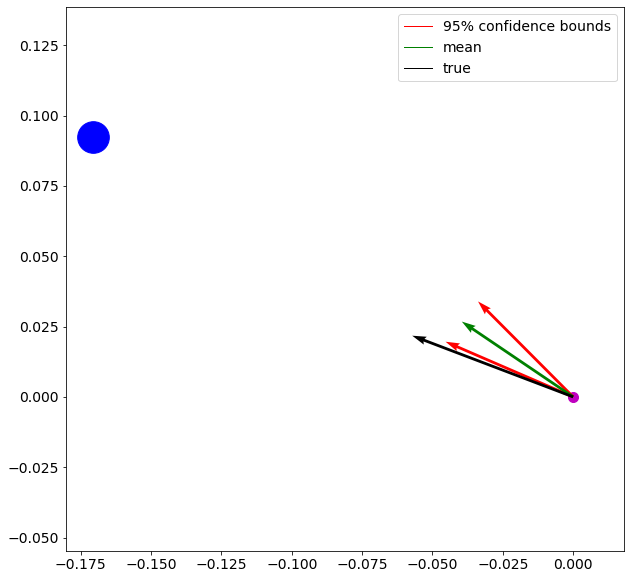

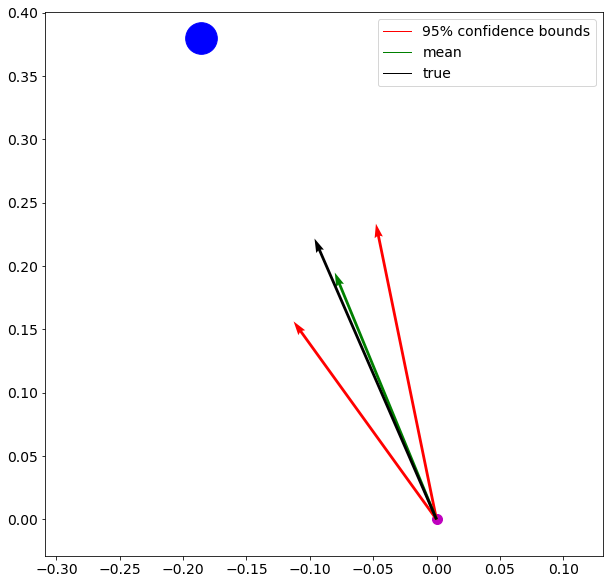

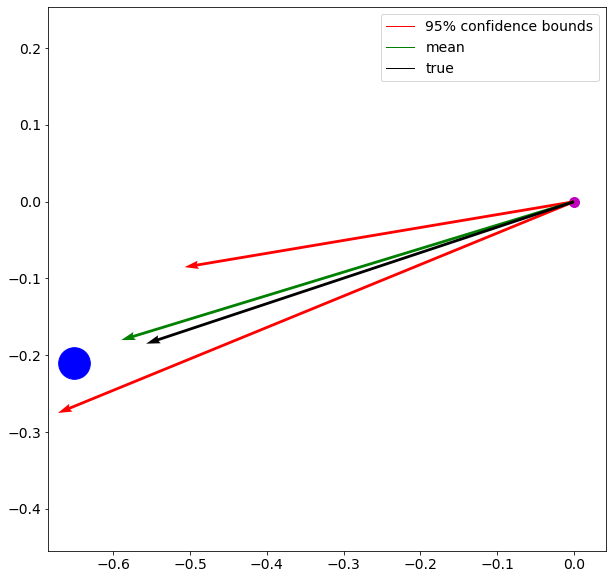

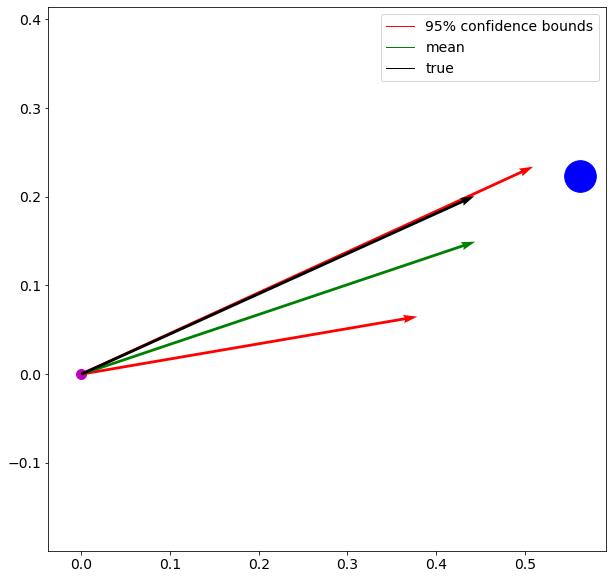

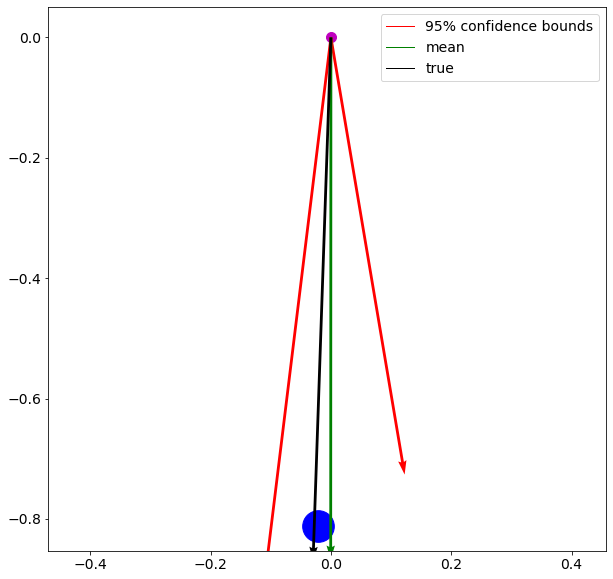

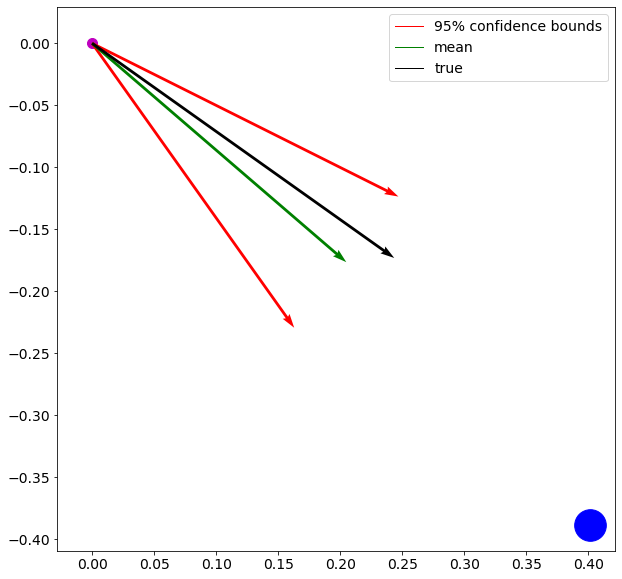

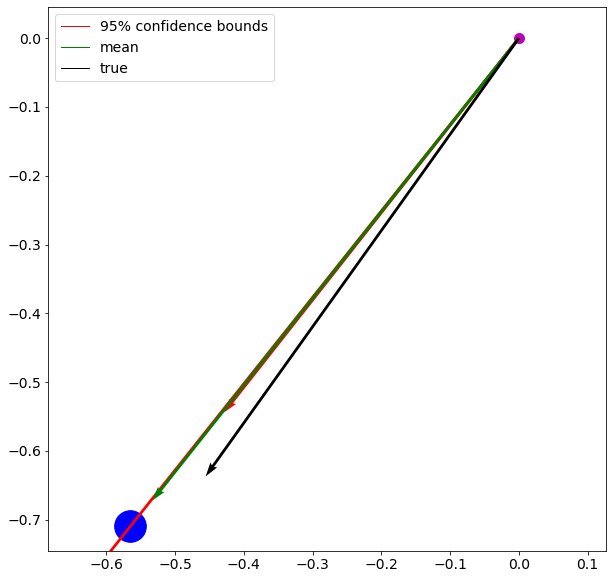

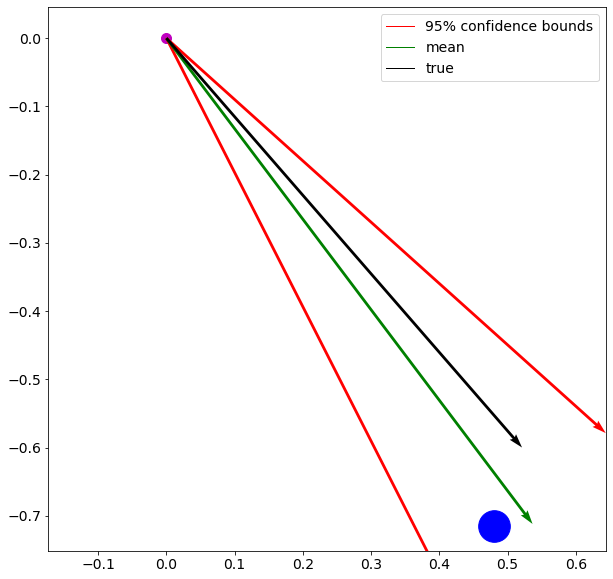

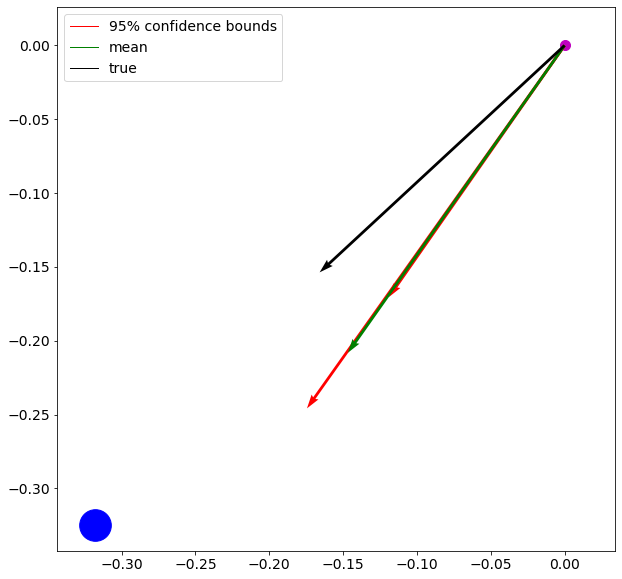

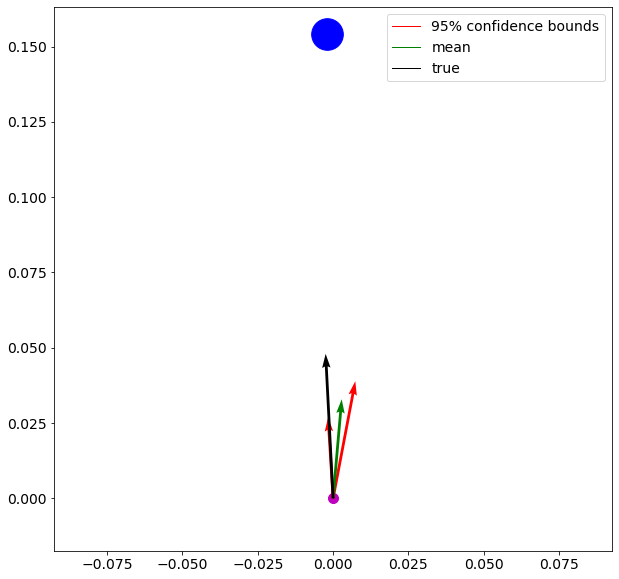

In [231]:
def plot_inv_prediction(inv_x, inv_y):
    inv_x = np.expand_dims(inv_x, axis=0)
    mu, sig = inv_model.model.predict_y(inv_x)
    s1 = np.array([[0, 0, 0, 0, 0, 0]])
    s2 = s1 + inv_x

    plt.figure(figsize=(10,10))
    plt.scatter(0, 0, color='m', s=100)
    plt.scatter(s2[0,4], s2[0,5], color='b', s=1000)
    mu_cos = mu[0, 0]
    lower_bound_cos = mu_cos - 1.96 * sig[0, 0]
    upper_bound_cos = mu_cos + 1.96 * sig[0, 0]
    mu_sin = mu[0, 1]
    lower_bound_sin = mu_sin - 1.96 * sig[0, 1]
    upper_bound_sin = mu_sin + 1.96 * sig[0, 1]
    mu_mag = mu[0, 2]
    plt.quiver([s1[0,4], s1[0,4], s1[0,4], s1[0,4]],
               [s1[0,5], s1[0,5], s1[0,5], s1[0,5]],
               [lower_bound_cos * mu_mag, upper_bound_cos * mu_mag, mu_cos * mu_mag, inv_y[0] * inv_y[2]],
               [lower_bound_sin * mu_mag, upper_bound_sin * mu_mag, mu_sin * mu_mag, inv_y[1] * inv_y[2]],
               color=['r', 'r', 'g', 'k'],
               width=0.005,
               scale=1,
              )
    plt.axis("equal")
    custom_lines = [Line2D([0], [0], color='red', lw=1),
                    Line2D([0], [0], color='green', lw=1),
                    Line2D([0], [0], color='black', lw=1),
                   ]

    l = plt.legend(custom_lines, ['95% confidence bounds', 'mean', 'true'])
    
for i in range(10):
    test_idx = 50 * i
    plot_inv_prediction(test_inverse_combined_x[test_idx], test_inverse_y[test_idx])

In [198]:
mu, sig = inv_model.model.predict_y(test_inverse_combined_x)
print(np.min(mu, axis=0))

[-1.0441 -1.0351  0.1403]


# Profiling the GP prediction

In [189]:
%%timeit
x_star = np.random.randn(1,8)
fwd_model.model.predict_y(x_star)

8.26 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [233]:
%%timeit
x_star = np.random.randn(1,6)
inv_model.model.predict_y(x_star)

5.07 ms ± 44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
